In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import datetime
import open3d as o3d
import os
import matplotlib.pyplot as plt

import wire_detection_utils as wdu

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [ ]:
expansion_size = 3
line_threshold = 100
pixel_binning_size = 3
low_canny_threshold =25
high_canny_threshold = 200
bin_avg_threshold_multiplier = 0.5
value_threshold = 0.5

input_image_size = [480, 270]

# Creat e a WireDetector instance
wire_detector = wdu.WireDetector(line_threshold, expansion_size, low_canny_threshold, high_canny_threshold, pixel_binning_size, bin_avg_threshold_multiplier)

target_timestamp = 1746650652972994304
folder = '/media/tyler/Storage/field_tests/street_wire_experiments/wire_tracking_05-07_40fov/'

rgb_folder = folder + 'rgb_images/'
depth_folder = folder + 'depth_images/'
camera_intrinsics_file = folder + 'rgb_camera_intrinsics.npy'
camera_intrinsics = np.load(camera_intrinsics_file)

closest_rgb_timestamp = None
closest_depth_timestamp = None
for image_name in os.listdir(rgb_folder):
    if image_name.endswith('.png'):
        timestamp = int(image_name.split('.')[0])
        if closest_rgb_timestamp is None or abs(timestamp - target_timestamp) < abs(closest_rgb_timestamp - target_timestamp):
            closest_rgb_timestamp = timestamp
for image_name in os.listdir(depth_folder):
    if image_name.endswith('.npy'):
        timestamp = int(image_name.split('.')[0])
        if closest_depth_timestamp is None or abs(timestamp - target_timestamp) < abs(closest_depth_timestamp - target_timestamp):
            closest_depth_timestamp = timestamp

rgb_image = str(closest_rgb_timestamp) + '.png'
depth_image = str(closest_depth_timestamp) + '.npy'

print(f"Time difference between closest RGB and depth images: {abs(closest_rgb_timestamp - closest_depth_timestamp)}")
    
img = cv2.imread(rgb_folder + rgb_image)
depth = np.load(depth_folder + depth_image)
assert img is not None, "Image not found"
assert depth is not None, "Depth image not found"

Time difference between closest RGB and depth images: 4575168


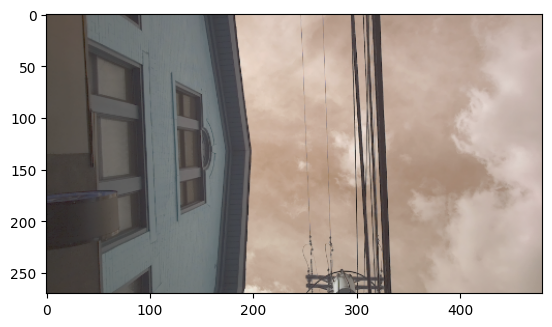

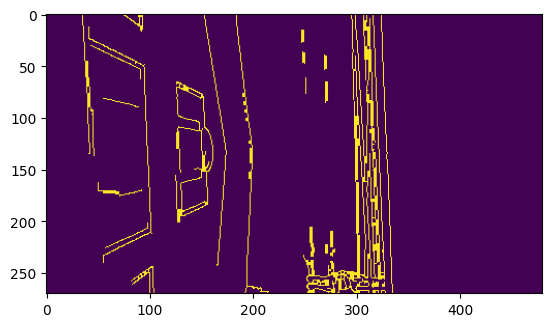

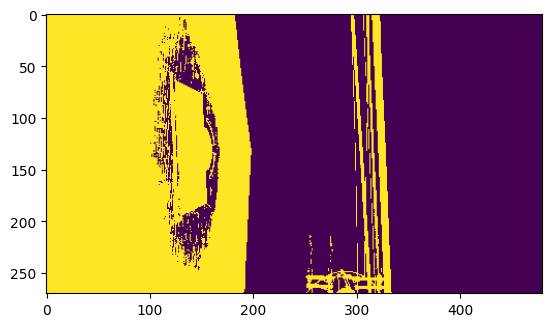

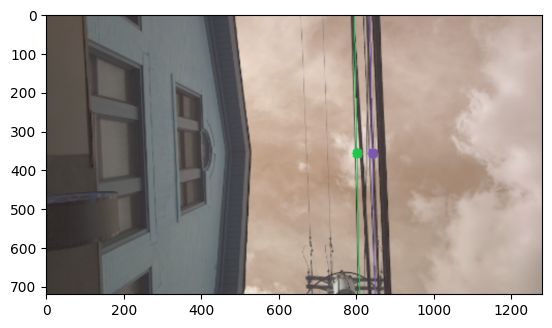

In [ ]:
img = cv2.resize(img, (input_image_size[0], input_image_size[1]))
depth = cv2.resize(depth, (input_image_size[0], input_image_size[1]))
cv2.imwrite('detect_3d_output/reference.jpg', img)
plt.figure()
plt.imshow(img)

# Create segmentation mask
seg_mask = wire_detector.create_seg_mask(img)
cv2.imwrite('detect_3d_output/seg_mask.jpg', seg_mask)
plt.figure()
plt.imshow(seg_mask)

wire_lines, wire_midpoints, avg_angle = wire_detector.detect_wires_2d(seg_mask)

img_2d_detect = img.copy()
rand_colors = np.random.randint(0, 256, (len(wire_midpoints), 3)).tolist()
for i, (x0,y0,x1,y1) in enumerate(wire_lines):
    cv2.line(img_2d_detect, (x0,y0), (x1,y1), tuple(rand_colors[i]), 1)

for i, (x0,y0) in enumerate(wire_midpoints):
    cv2.circle(img_2d_detect, (int(x0), int(y0)), 5, tuple(rand_colors[i]), -1)

img_2d_detect = cv2.resize(img_2d_detect, (1280, 720))
end_time = datetime.datetime.now()
cv2.imwrite('detect_3d_output/wire2d_detect.jpg', img_2d_detect)
plt.figure()
plt.imshow(img_2d_detect)

In [9]:

min_depth = 0.5
depth[depth <= min_depth] = 0

# Convert depth image to Open3D format
depth_o3d = o3d.geometry.Image(depth.astype(np.float32))

# Create an Open3D RGBD image
rgb_o3d = o3d.geometry.Image(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
rgbd_image = o3d.geometry.RGBDImage.create_from_color_and_depth(
    color=rgb_o3d,
    depth=depth_o3d,
    depth_scale=1.0,  # Adjust based on your depth scale
    depth_trunc=20.0,  # Truncate depth values beyond this distance
    convert_rgb_to_intensity=False
)

# Create a pinhole camera intrinsic object
intrinsics = o3d.camera.PinholeCameraIntrinsic(
    width=input_image_size[0],
    height=input_image_size[1],
    fx=camera_intrinsics[0, 0],
    fy=camera_intrinsics[1, 1],
    cx=camera_intrinsics[0, 2],
    cy=camera_intrinsics[1, 2]
)

point_cloud = o3d.geometry.PointCloud.create_from_rgbd_image(
    rgbd_image,
    intrinsics
)


# Visualize the point cloud
o3d.visualization.draw_geometries([point_cloud], point_show_normal=True)